<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-04-02 19:21:54--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2021-04-02 19:21:55 (9.82 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  anaconda
    _py-xgboost-mutex-2.0      |            cpu_0           9 KB  anaconda
    _pytorch_select-0.1        |            cpu_0           2 KB  anaconda
    absl-py-0.10.0             |           py37_0         169 KB  anaconda
    aiohttp-3.6.3              |   py37h7b6447c_0         626 KB  anaconda
    argon2-cffi-20.1.0         |   py37h7b6447c_1         

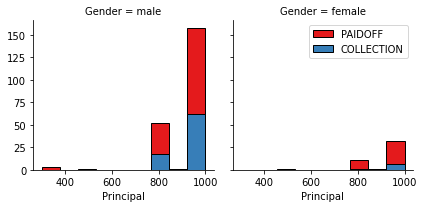

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

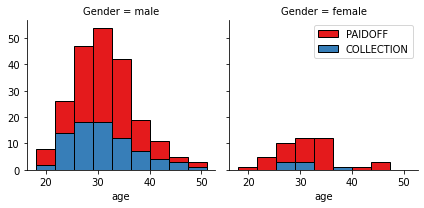

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

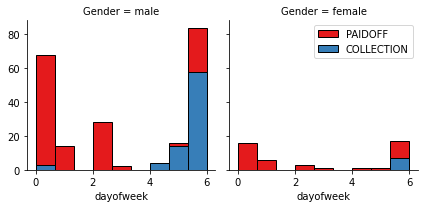

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
##
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [22]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


In [23]:
k = 5
neigh5 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat5 = neigh5.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh5.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat5))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.7571428571428571


In [24]:
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))


Train set Accuracy:  0.8007246376811594
Test set Accuracy:  0.7142857142857143


# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))



Shape of X training set (242, 8) &  Size of Y training set (242,)
Shape of X training set (104, 8) &  Size of Y training set (104,)


In [26]:
debtTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
debtTree # it shows the default parameters
debtTree.fit(X_trainset,y_trainset)
predTree = debtTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


In [27]:
#evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6538461538461539


In [28]:
#
#!conda install -c conda-forge python-graphviz -y
#pip install six
#pip install --upgrade mglearn
!pip install --upgrade scikit-learn==0.20.3

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 5.4 MB 13.7 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [29]:
!pip install pydotplus

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 278 kB 18.5 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=1b3738283c4d7671a6b1c3bd5dfdb4de2312c01713f71edf7e93bd7325b3ec21
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [30]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

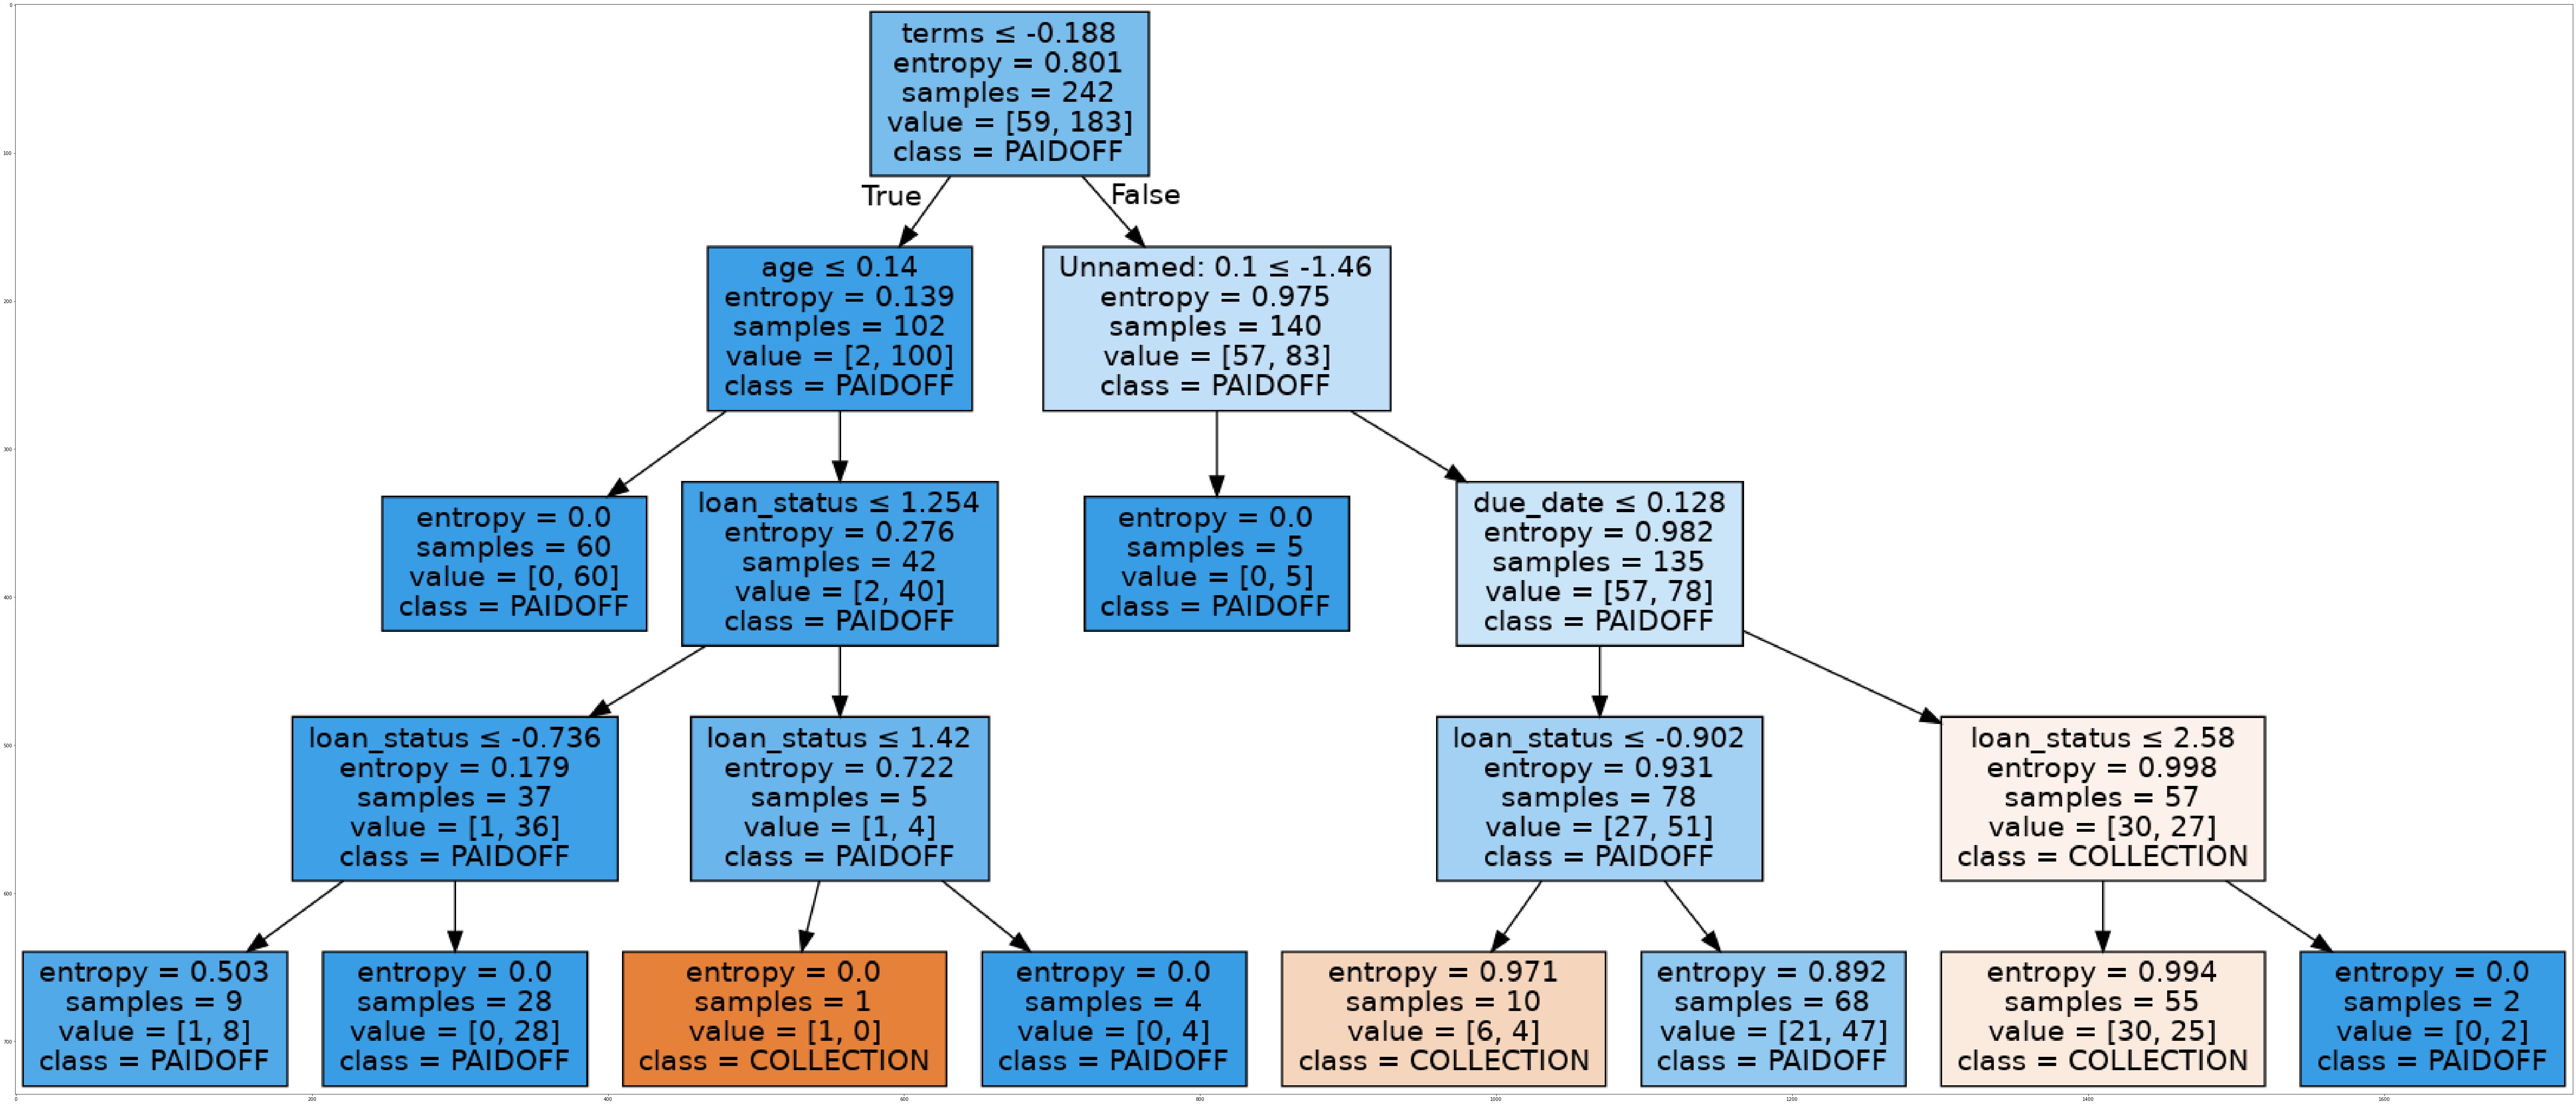

In [31]:
dot_data = StringIO()
filename = "debtTree.png"
featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()

out=tree.export_graphviz(debtTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [32]:
from sklearn.neighbors import KNeighborsClassifier
##
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
yhat [0:5]

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


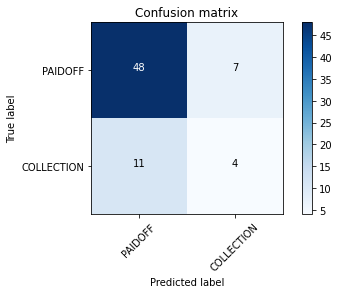

In [35]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

#cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])

np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [36]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 
from sklearn.metrics import jaccard_score

jaccard_score(y_test, yhat, pos_label='PAIDOFF')

0.7272727272727273

In [37]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))

print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2, pos_label='PAIDOFF'))

Avg F1-score: 0.6914
Jaccard score: 0.7857


# Logistic Regression

In [38]:
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)


In [39]:
yhat = LR.predict(X_test)
yhat

yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.52, 0.48],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.37, 0.63],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.5 ,

In [40]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,  pos_label='PAIDOFF')
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [41]:
#log_loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5772287609479654

In [42]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))

LogLoss: : 0.49


# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-02 19:30:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-02 19:30:35 (81.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
#test_df.shape #(54,10)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Preprocessing


In [46]:
#Convert to dte time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [47]:
test_df['loan_status'].value_counts()
#PAIDOFF: 40
#COLLECTION: 14

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

# Prelim Viz

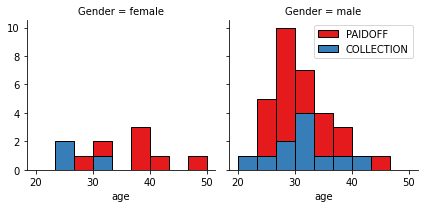

In [48]:
bins = np.linspace(test_df.age.min(), test_df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

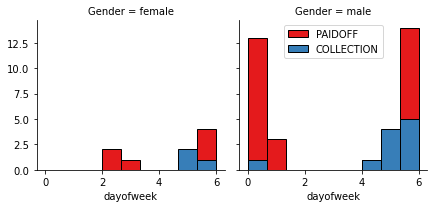

In [49]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

If we're gonna run this data through the same models, I'm going to do the same prelim data processing. 


In [50]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


# Convert Categorical features to numerical values
1) start with gender

In [51]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
#72 % of females pay off their loans  and 74% of males pay off their loan

#Convert male to 0 & female to 1:

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


# One Hot Encoding
Education: 

In [52]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

#Feature before One Hot Encoding
test_df[['Principal','terms','age','Gender','education']].head()
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [53]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


# Feature selection


In [54]:
#start here
#Define feature sets, X:
X = Feature
X[0:5]
#lables

y = test_df['loan_status'].values
y[0:5]

#normalize data
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

# K Nearest Neighbor

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
#print ('Train set:', X_train.shape,  y_train.shape)
X_test = X
y_test = y 
print ('Test set:', X_test.shape,  y_test.shape)

Test set: (54, 8) (54,)


In [76]:
from sklearn import metrics
k = 5
neigh5 = KNeighborsClassifier(n_neighbors = k).fit(X_test,y_test)
yhat5 = neigh5.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat5))

#Test set Accuracy:  0.888
f1_score(y_test, yhat5, average='weighted')

Test set Accuracy:  0.8888888888888888


TypeError: 'NoneType' object is not callable

# Decision Tree

Shape of X training set (37, 8) &  Size of Y training set (37,)
Shape of X training set (17, 8) &  Size of Y training set (17,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
DecisionTrees's Accuracy:  0.7407407407407407
0.7358490566037735


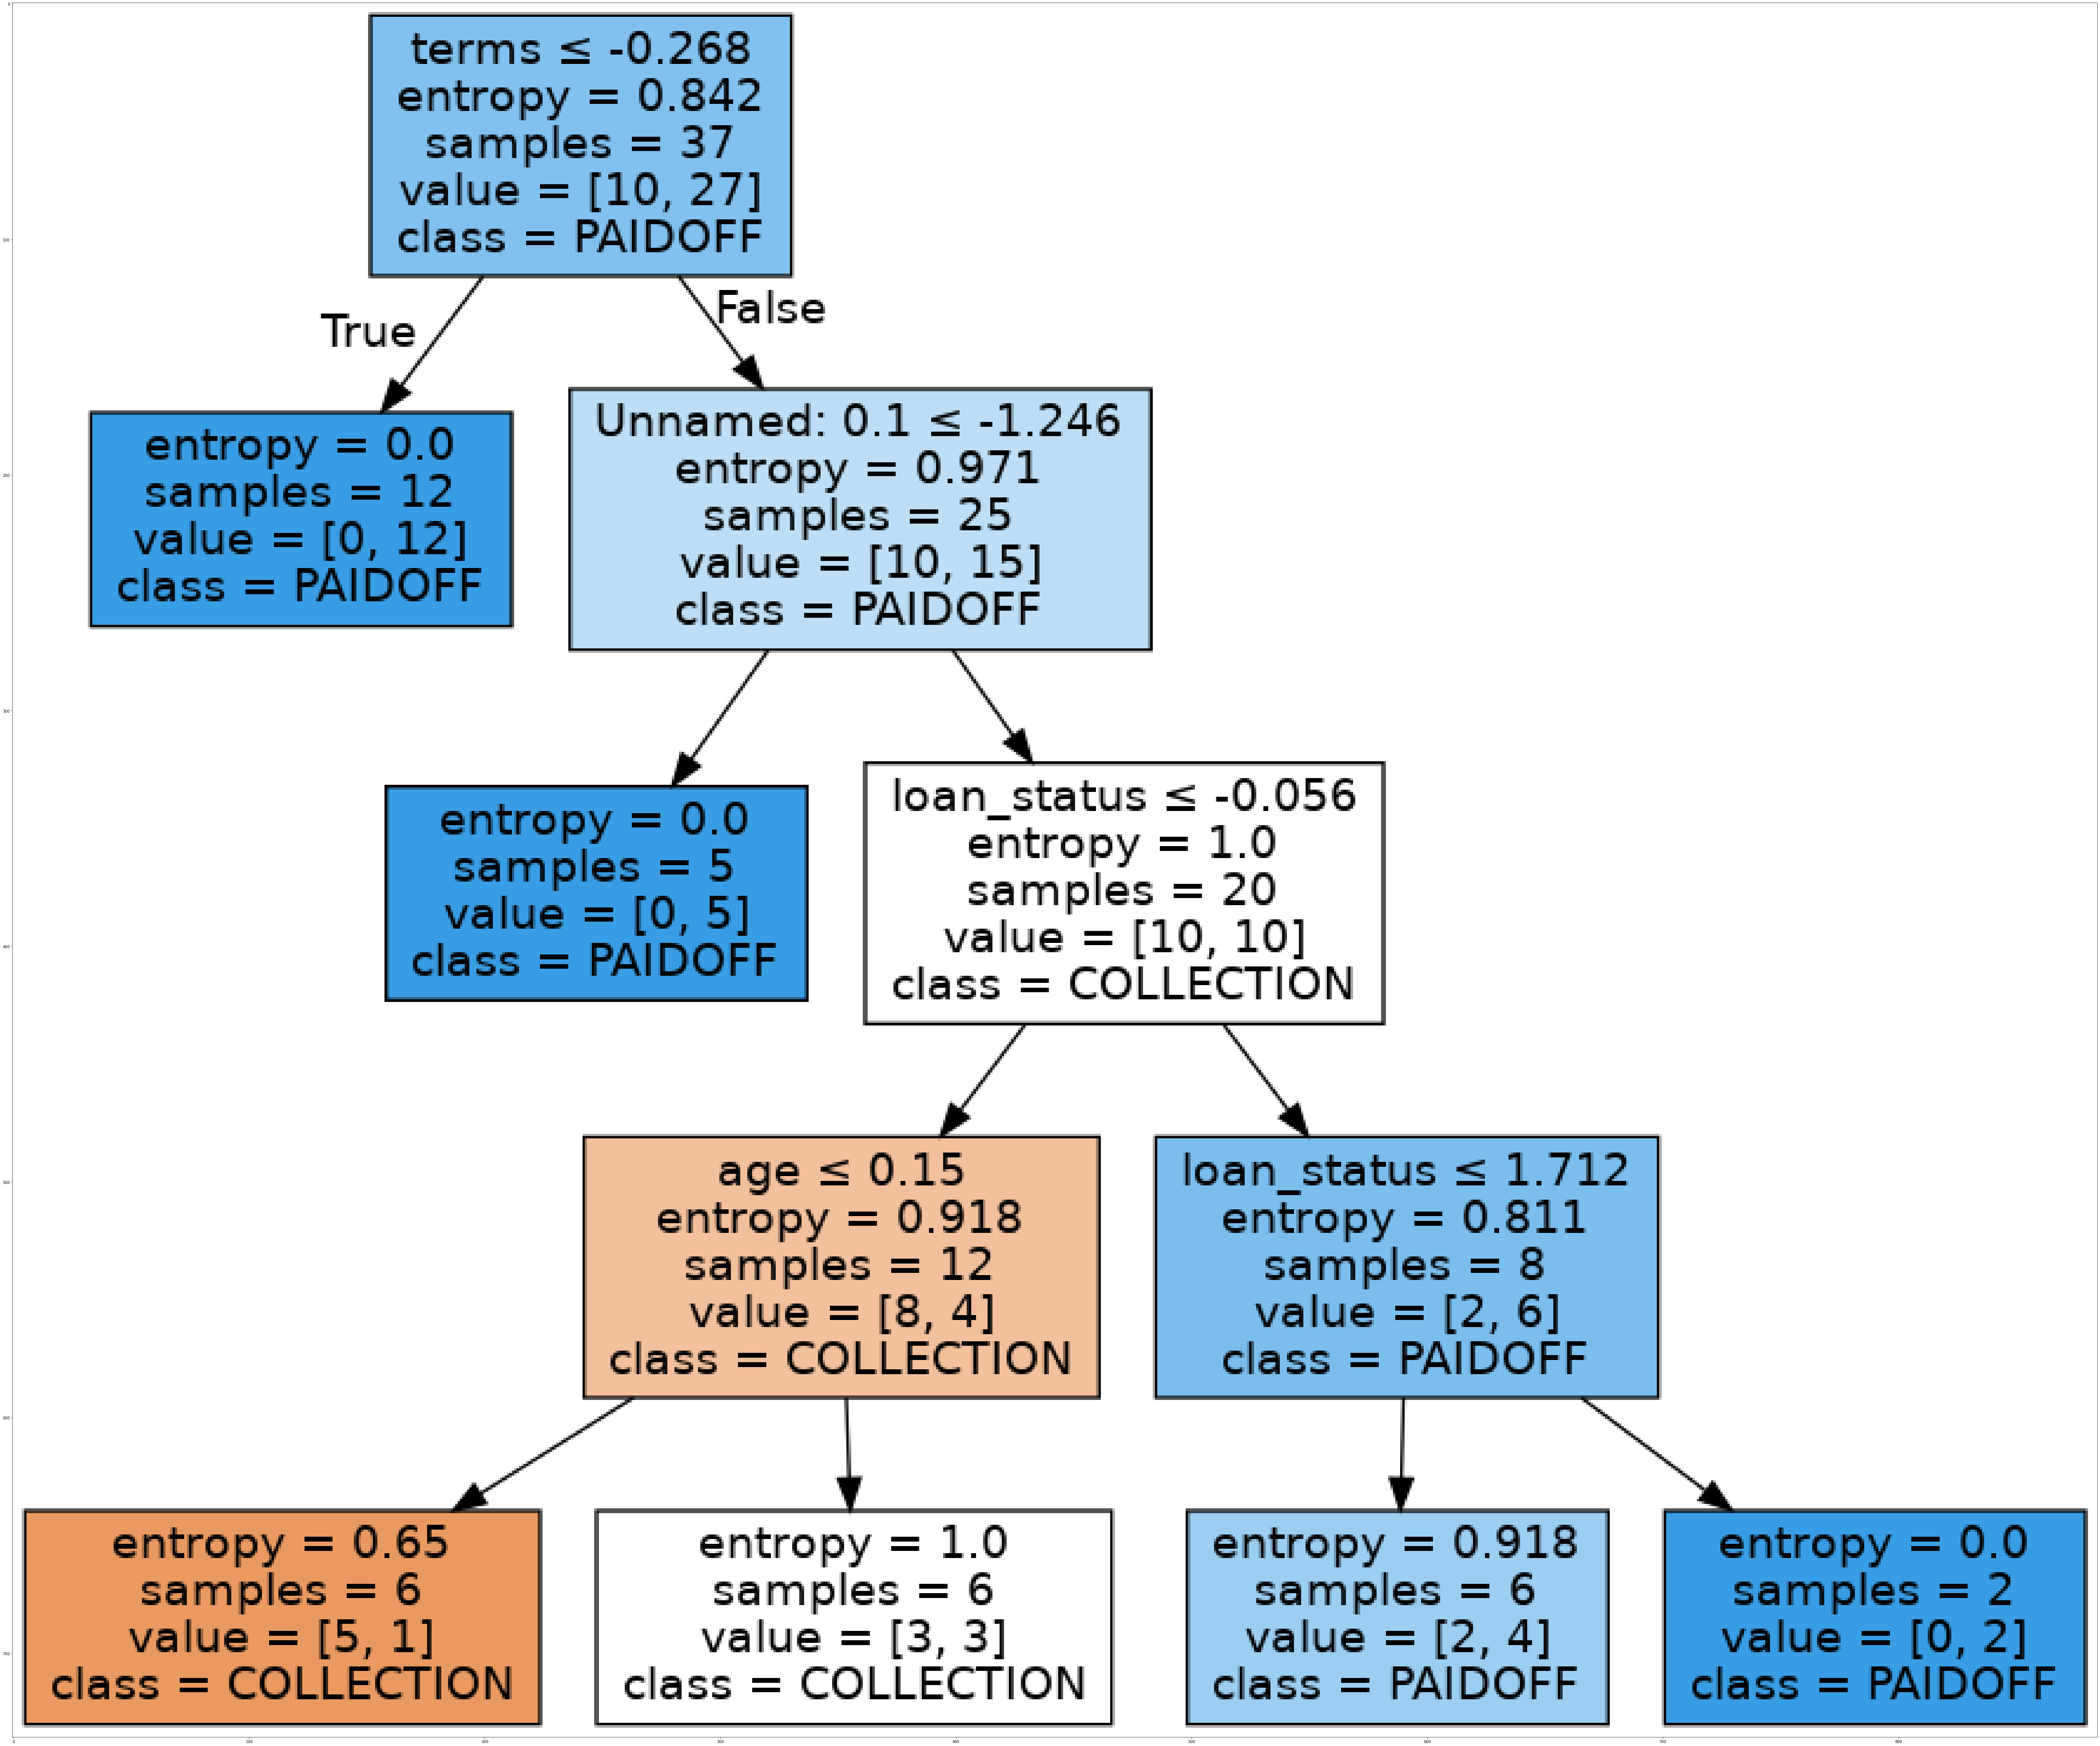

In [63]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))
X_testset = X
y_testset = y


debtTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
debtTree # it shows the default parameters
debtTree.fit(X_trainset,y_trainset)
predTree = debtTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

#evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))


%matplotlib inline 
dot_data = StringIO()
filename = "debtTree.png"
featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()



out=tree.export_graphviz(debtTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  



graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')
#DecisionTrees's Accuracy:  0.7407407407407407

print(jaccard_score(y_test, yhat,  pos_label='PAIDOFF'))
#jaccard score: .73

# Support Vector Machine

In [58]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
yhat [0:5]

Train set: (43, 8) (43,)
Test set: (11, 8) (11,)


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         1
     PAIDOFF       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

Confusion matrix, without normalization
[[10  0]
 [ 1  0]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


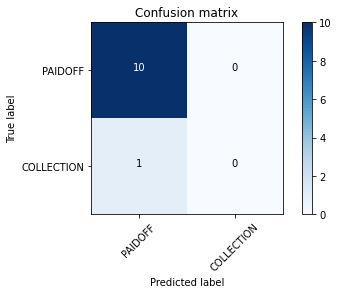

In [60]:
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

#cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])

np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [61]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 
from sklearn.metrics import jaccard_score

jaccard_score(y_test, yhat, pos_label='PAIDOFF')

clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2, pos_label='PAIDOFF'))
#Avg F1-score: 0.6417
#Jaccard score: 0.5455

Avg F1-score: 0.6417
Jaccard score: 0.5455


# Logistic Regression

In [57]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

yhat = LR.predict(X_test)
yhat

yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.25, 0.75],
       [0.41, 0.59],
       [0.43, 0.57],
       [0.51, 0.49],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.43, 0.57],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.41, 0.59],
       [0.49, 0.51],
       [0.44, 0.56],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.42, 0.58],
       [0.4 , 0.6 ],
       [0.49, 0.51],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.25, 0.75],
       [0.31, 0.69],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.31, 0.69],
       [0.29, 0.71],
       [0.31, 0.69],
       [0.33, 0.67],
       [0.33, 0.67],
       [0.3 , 0.7 ],
       [0.33, 0.67],
       [0.33, 0.67],
       [0.3 , 0.7 ],
       [0.33, 0.67],
       [0.34, 0.66],
       [0.31, 0.69],
       [0.28, 0.72],
       [0.29, 0.71],
       [0.49, 0.51],
       [0.43, 0.57],
       [0.43, 0.57],
       [0.5 , 0.5 ],
       [0.44, 0.56],
       [0.53, 0.47],
       [0.49, 0.51],
       [0.48,

In [61]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_test, yhat,  pos_label='PAIDOFF'))

print (classification_report(y_test, yhat))

0.7358490566037735
              precision    recall  f1-score   support

  COLLECTION       0.50      0.07      0.12        14
     PAIDOFF       0.75      0.97      0.85        40

    accuracy                           0.74        54
   macro avg       0.62      0.52      0.49        54
weighted avg       0.69      0.74      0.66        54



In [62]:
#log_loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)
0.5772287609479654
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))
#LogLoss: : 0.52

LogLoss: : 0.52


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | .88     |.66       | NA      |
| Decision Tree      | .74     |.73       | NA      |
| SVM                | .54     |.64       | NA      |
| LogisticRegression | .735    |.66       | .52     |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>